In [1]:
# pomocnicze
import re
import numpy as np
import pandas as pd
import string
# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk - do preprocessingu
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
!python -m pip install spacy==2.3.2 -q

In [3]:
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50.8 MB 1.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
#1B – gotowe dane
dataset = pd.read_csv('Twitter_Data_KAGGLE.csv', index_col=False)
dataset.sample(5) # wyświetl N przykładowych wierszy

,clean_text,category
109489,this expected gives clean chit narendra modis ...,1.0
46069,modi launches various development projects kan...,0.0
6348,accidental producer involved siphoning off mon...,1.0
120558,left his kingdom like gautama buddha left his ...,1.0
105378,pmmodi today from meerut began rallies for the...,-1.0


In [5]:
# podział danych względem kategorii/sentymentu
# negative(-1), neutral(0), and positive(+1)
data_pos = dataset[dataset['category'] == 1]
data_neg = dataset[dataset['category'] == -1]
data_neu = dataset[dataset['category'] == 0]

# ograniczenie danych do modelowania
data_pos = data_pos.iloc[:50000]
data_neg = data_neg.iloc[:50000]
data_neu = data_neu.iloc[:50000]

dataset = pd.concat([data_pos, data_neg, data_neu])

In [6]:
# Pre-processing danych
# usuwanie NULLi
dataset.dropna(inplace=True)

In [7]:
# zamiana na małe litery
dataset['clean_text'] = dataset['clean_text'].str.lower() # za pomocą klasy string
dataset['clean_text'].head()

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object

In [8]:
# usuwanie stowords
# po instalacji spacy, uruchomić ponownie środowisko wykonawcze
nlp = spacy.load('en_core_web_md')
stopwordlist = nlp.Defaults.stop_words

In [9]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])

dataset['clean_text'] = dataset['clean_text'].apply(cleaning_stopwords)
dataset['clean_text'].head()

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object

In [11]:
# usuwanie znakow interpunkcyjnych
punctuations_list = string.punctuation
punctuations_list += ('“')

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [12]:
dataset['clean_text'] = dataset['clean_text'].apply(cleaning_punctuations)
dataset['clean_text'].head()

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object

In [13]:
# usuwanie znaków
def clean_sings(text):
  text = text.replace('ï', '')
  text = text.replace('½', '')
  return text.replace('¿', '')

In [14]:
dataset['clean_text'] = dataset['clean_text'].apply(clean_sings)
dataset['clean_text'].head()

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object

In [15]:
# usuwanie powtarzających się znaków
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

# usuwanie linków
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

# usuwanie liczb
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
  
dataset['clean_text'] = dataset['clean_text'].apply(cleaning_repeating_char)
dataset['clean_text'] = dataset['clean_text'].apply(cleaning_URLs)
dataset['clean_text'] = dataset['clean_text'].apply(cleaning_numbers)  

dataset['clean_text'].tail()

147585    whats modis india india has always remained in...
147586                          she dont know abc modi work
147589    hai jogi matalb votes liye congress kuch bhi k...
147607    institution including judiciary independent un...
147608    the number one interview the biggest election ...
Name: clean_text, dtype: object

In [16]:
# lematyzacja
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['clean_text'] = dataset['clean_text'].apply(lemmatizer_on_text)
dataset['clean_text'].head()

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object

In [18]:
# wycięcie danych dla klasy negative i positive do klasycznego ML
data = dataset.copy()
data.loc[data.index.isin([-1,1])]
#negative(-1), neutral(0), and positive(+1)
data['category'] = data['category'].replace(-1,0) # zamiana etykiety

X = data.clean_text
y = data.category
print(X.head())
print(y.head())

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object
2    1.0
3    1.0
4    1.0
8    1.0
9    1.0
Name: category, dtype: float64


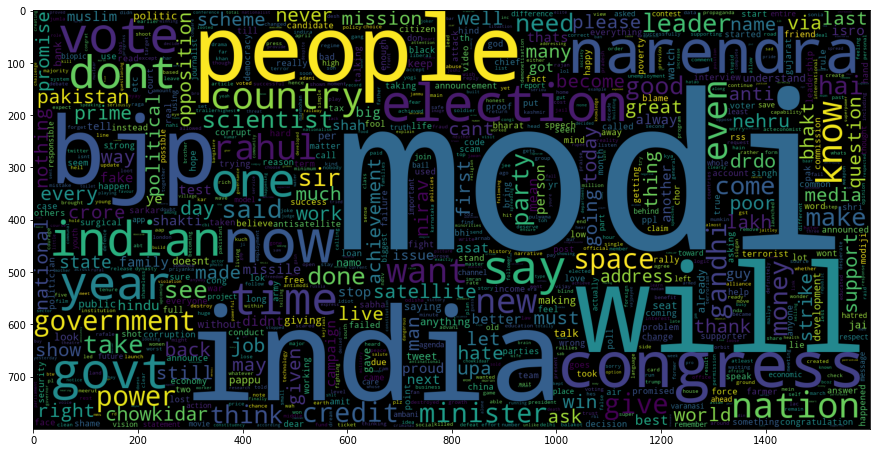

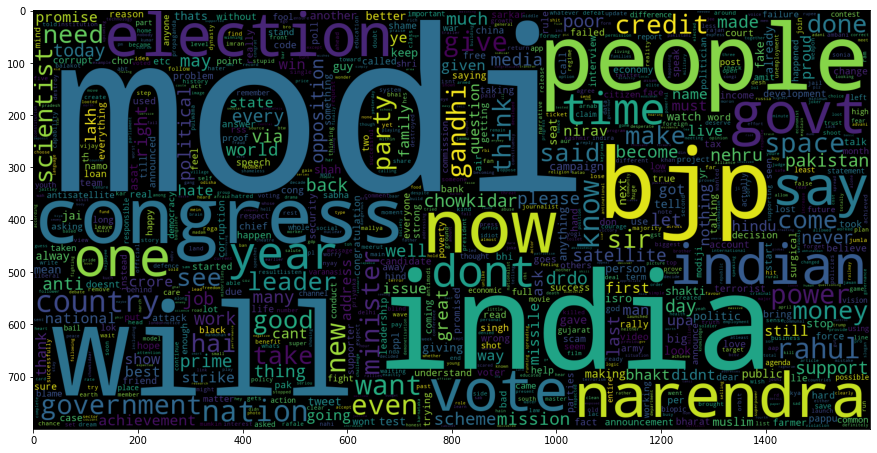

In [19]:
# chmura tagów
data_neg = dataset['clean_text']
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

data_pos = dataset['clean_text']
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

In [20]:
# podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [21]:
# Zamiana na wektory z użyciem TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [22]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [23]:
print(X_train)

  (0, 472571)	0.24589156729522776
  (0, 471367)	0.06539173631895463
  (0, 456994)	0.3809708650947212
  (0, 456467)	0.1675408502667729
  (0, 445286)	0.14583605774371095
  (0, 443602)	0.07131891552404665
  (0, 347625)	0.2317099224828172
  (0, 347602)	0.12549155900890938
  (0, 151446)	0.21511846165520343
  (0, 151315)	0.10127826207835716
  (0, 129161)	0.2175282776704066
  (0, 127731)	0.02401778135082713
  (0, 118799)	0.23759583688142089
  (0, 118778)	0.12018282784064976
  (0, 104315)	0.19341324556281414
  (0, 104254)	0.14944362050979945
  (0, 104244)	0.21913056127647063
  (0, 85229)	0.22026030174064484
  (0, 69923)	0.1562362285239358
  (0, 67292)	0.1465402882494563
  (0, 59667)	0.21511846165520343
  (0, 59496)	0.09783023018751708
  (0, 48410)	0.09403137014728725
  (0, 45286)	0.1891649880455855
  (0, 45279)	0.1699126677017159
  :	:
  (121955, 61851)	0.22878328477380078
  (121955, 58207)	0.197525065673955
  (121955, 58206)	0.19626035820132598
  (121955, 41825)	0.23707475739893236
  (121955,

In [24]:
# Ewaluacja modelu - funkcja
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  #print(cf_matrix.shape)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  #print(labels.shape)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
# ETAP 2: KLASYCZNY ML

              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      8514
         1.0       0.86      0.51      0.64      5037

    accuracy                           0.79     13551
   macro avg       0.81      0.73      0.74     13551
weighted avg       0.80      0.79      0.77     13551



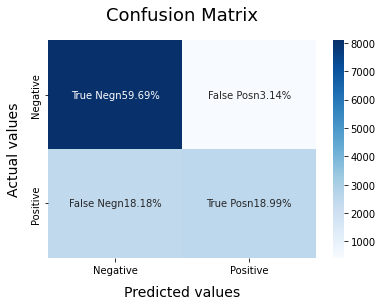

In [26]:
# Naive Bayes - Bernoulli
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

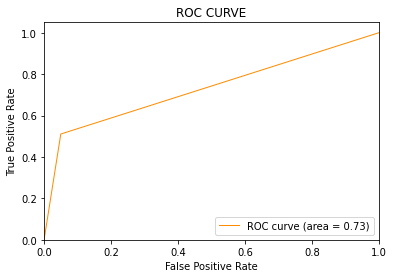

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      8514
         1.0       0.93      0.91      0.92      5037

    accuracy                           0.94     13551
   macro avg       0.94      0.94      0.94     13551
weighted avg       0.94      0.94      0.94     13551



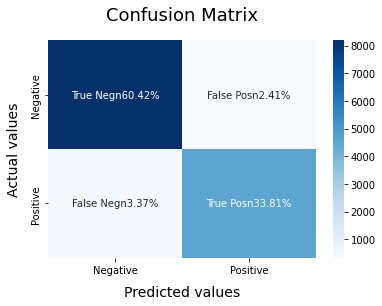

In [28]:
# Linear Suppor Vector
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

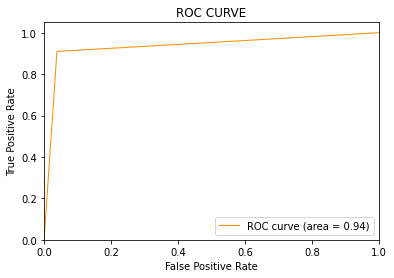

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      8514
         1.0       0.93      0.81      0.86      5037

    accuracy                           0.91     13551
   macro avg       0.91      0.89      0.90     13551
weighted avg       0.91      0.91      0.90     13551



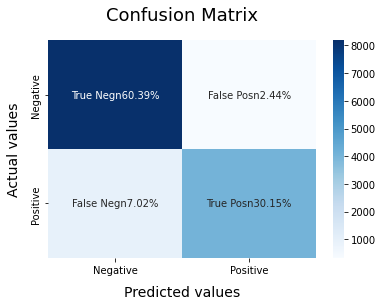

In [30]:
# Logistic Regression
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

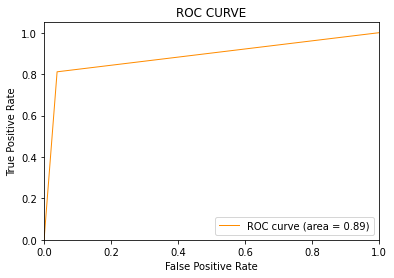

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ETAP 3: MODEL NN

In [32]:
def clean_data(data):
    
    # Usuwanie url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Usuwanie emaili
    data = re.sub('\S*@\S*\s?', '', data)

    # Usuwanie znaków nowej linii
    data = re.sub('\n', ' ', data)

    # Usuwanie apostrofów
    data = re.sub("\'", "", data)
        
    return data

In [33]:
temp = []

data_to_list = dataset['clean_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_data(data_to_list[i]))
list(temp[:5])

['what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax',
 'asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars',
 'answer who among these the most powerful world leader today trump putin modi may ',
 'with upcoming election india saga going important pair look current modi leads govt elected with deal brexit combination this weekly looks juicy bears imho ',
 'gandhi was gay does modi  ']

In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['what', 'did', 'just', 'say', 'vote', 'for', 'modi', 'welcome', 'bjp', 'told', 'you', 'rahul', 'the', 'main', 'campaigner', 'for', 'modi', 'think', 'modi', 'should', 'just', 'relax'], ['asking', 'his', 'supporters', 'prefix', 'chowkidar', 'their', 'names', 'modi', 'did', 'great', 'service', 'now', 'there', 'confusion', 'what', 'read', 'what', 'not', 'now', 'crustal', 'clear', 'what', 'will', 'crass', 'filthy', 'nonsensical', 'see', 'how', 'most', 'abuses', 'are', 'coming', 'from', 'chowkidars'], ['answer', 'who', 'among', 'these', 'the', 'most', 'powerful', 'world', 'leader', 'today', 'trump', 'putin', 'modi', 'may'], ['with', 'upcoming', 'election', 'india', 'saga', 'going', 'important', 'pair', 'look', 'current', 'modi', 'leads', 'govt', 'elected', 'with', 'deal', 'brexit', 'combination', 'this', 'weekly', 'looks', 'juicy', 'bears', 'imho'], ['gandhi', 'was', 'gay', 'does', 'modi'], ['things', 'like', 'demonetisation', 'gst', 'goods', 'and', 'services', 'tax', 'the', 'upper', 'cast

In [35]:
for i in range(len(data_words)):
  data_words[i] = [word for word in data_words[i] if word not in stopwordlist]

print(data_words[:10])

[['vote', 'modi', 'welcome', 'bjp', 'told', 'rahul', 'main', 'campaigner', 'modi', 'think', 'modi', 'relax'], ['asking', 'supporters', 'prefix', 'chowkidar', 'names', 'modi', 'great', 'service', 'confusion', 'read', 'crustal', 'clear', 'crass', 'filthy', 'nonsensical', 'abuses', 'coming', 'chowkidars'], ['answer', 'powerful', 'world', 'leader', 'today', 'trump', 'putin', 'modi'], ['upcoming', 'election', 'india', 'saga', 'going', 'important', 'pair', 'look', 'current', 'modi', 'leads', 'govt', 'elected', 'deal', 'brexit', 'combination', 'weekly', 'looks', 'juicy', 'bears', 'imho'], ['gandhi', 'gay', 'modi'], ['things', 'like', 'demonetisation', 'gst', 'goods', 'services', 'tax', 'upper', 'castes', 'sort', 'view', 'favourably', 'need', 'time', 'castes', 'like', 'dalits', 'muslims', 'modi', 'constituency'], ['hope', 'tuthukudi', 'people', 'prefer', 'honest', 'behaved', 'nationalist', 'courageous', 'likly', 'minister', 'modi', 'cabinet', 'vote', 'benifit', 'thuthukudi'], ['calm', 'waters'

In [36]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [37]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['vote modi welcome bjp told rahul main campaigner modi think modi relax', 'asking supporters prefix chowkidar names modi great service confusion read crustal clear crass filthy nonsensical abuses coming chowkidars', 'answer powerful world leader today trump putin modi', 'upcoming election india saga going important pair look current modi leads govt elected deal brexit combination weekly looks juicy bears imho', 'gandhi gay modi']


In [38]:
# negative(-1), neutral(0), and positive(+1)
dataset['category'] = dataset['category'].replace(1,2) # zamieniamy etykiety
dataset['category'] = dataset['category'].replace(0,1) # zamieniamy etykiety
dataset['category'] = dataset['category'].replace(-1,0) # zamieniamy etykiety
# po: negative(0), neutral(1), and positive(2)

X = dataset.clean_text
y = dataset.category
print(X.head())
print(y.head())
print(dataset.category.unique())

2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
8    with upcoming election india saga going import...
9                           gandhi was gay does modi  
Name: clean_text, dtype: object
2    2.0
3    2.0
4    2.0
8    2.0
9    2.0
Name: category, dtype: float64
[2. 0. 1.]


In [39]:
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
print(labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [40]:
len(labels) == len(data_words)

True

In [41]:
# Zamiana danych na tensory
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   36    1 3758]
 [   0    0    0 ... 2194  204  739]
 [   0    0    0 ...  638 3381    1]
 ...
 [   0    0    0 ... 4928 4168    1]
 [   0    0    0 ... 1052   11  483]
 [   0    0    0 ...  478  653 4518]]


In [42]:
#podział danych
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

101631 33877 101631 33877


In [ ]:
#Single LSTM layer model
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax')) # warstwa klasyfikacji, 3 kategorie


model1.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.hdf5", 
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='auto',
                              period=1,
                              save_weights_only=False)

history = model1.fit(X_train, 
                     y_train, 
                     epochs=70,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint1])

Epoch 1/70
3173/3176 [============================>.] - ETA: 0s - loss: 0.6980 - accuracy: 0.6990
Epoch 1: val_accuracy improved from -inf to 0.82407, saving model to best_model1.hdf5
3176/3176 [==============================] - 39s 12ms/step - loss: 0.6979 - accuracy: 0.6991 - val_loss: 0.4922 - val_accuracy: 0.8241
Epoch 2/70
3172/3176 [============================>.] - ETA: 0s - loss: 0.4741 - accuracy: 0.8355
Epoch 2: val_accuracy improved from 0.82407 to 0.85273, saving model to best_model1.hdf5
3176/3176 [==============================] - 38s 12ms/step - loss: 0.4742 - accuracy: 0.8355 - val_loss: 0.4476 - val_accuracy: 0.8527
Epoch 3/70
3171/3176 [============================>.] - ETA: 0s - loss: 0.4474 - accuracy: 0.8496
Epoch 3: val_accuracy improved from 0.85273 to 0.85929, saving model to best_model1.hdf5
3176/3176 [==============================] - 37s 12ms/step - loss: 0.4476 - accuracy: 0.8495 - val_loss: 0.4371 - val_accuracy: 0.8593
Epoch 4/70
3175/3176 [===============

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm_3 (LSTM)               (None, 15)                2160      
                                                                 
 dense_3 (Dense)             (None, 3)                 48        
                                                                 
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________


## Ewaluacja najlepszego modelu

In [43]:
# ładujemy najlepszy model
best_model = keras.models.load_model("best_model1.hdf5")

In [44]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

1059/1059 - 14s - loss: 0.9502 - accuracy: 0.7004 - 14s/epoch - 13ms/step
Model accuracy:  0.70035719871521


In [45]:
predictions = best_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


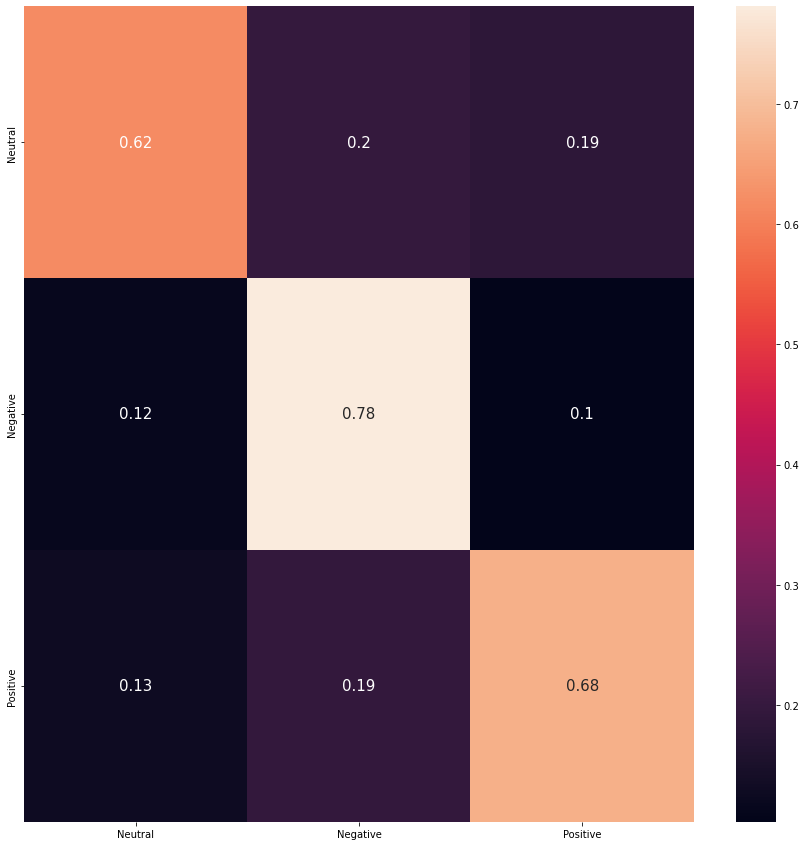

In [46]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral', 'Negative','Positive'],columns = ['Neutral', 'Negative','Positive'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})